In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def fetch_stock_data(symbol='AAPL', period='5y'):
    stock = yf.Ticker(symbol)
    data = stock.history(period=period)

    # Technical Indicators
    data['Returns'] = data['Close'].pct_change()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['Volatility'] = data['Returns'].rolling(window=20).std()

    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss.replace(0, np.nan))
    data['RSI'] = 100 - (100 / (1 + rs))

    features = ['Close', 'Volume', 'Returns', 'MA20', 'Volatility', 'RSI']
    return data[features].dropna(), features

def prepare_sliding_windows(data, seq_len=30):
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_norm) - seq_len):
        X.append(data_norm[i : i + seq_len])
        y.append(data_norm[i + seq_len, 0]) # Dự báo giá Close

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), scaler

# Thực thi load dữ liệu
df, feature_cols = fetch_stock_data('AAPL')
X_np, y_np, data_scaler = prepare_sliding_windows(df)

split = int(0.8 * len(X_np))
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_np[:split]), torch.from_numpy(y_np[:split])), batch_size=32, shuffle=True)
X_test_tensor = torch.from_numpy(X_np[split:]).to(device)
y_test_tensor = torch.from_numpy(y_np[split:]).to(device)


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class VanillaTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: [Batch, Seq, Features]
        x = self.input_proj(x)
        x = self.pos_encoder(x)

        # Causal mask để tránh rò rỉ dữ liệu tương lai
        mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(device)

        out = self.transformer_encoder(x, mask=mask, is_causal=True)
        return self.output_layer(out[:, -1, :]) # Lấy token cuối cùng

In [4]:
model = VanillaTransformer(num_features=len(feature_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = []
epochs = 50

print("Starting Training...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Starting Training...
Epoch [10/50], Loss: 0.008690
Epoch [20/50], Loss: 0.006417
Epoch [30/50], Loss: 0.005932
Epoch [40/50], Loss: 0.004740
Epoch [50/50], Loss: 0.004792



--- METRICS ---
MSE:  0.074221
RMSE: 0.272435
MAE:  0.212962


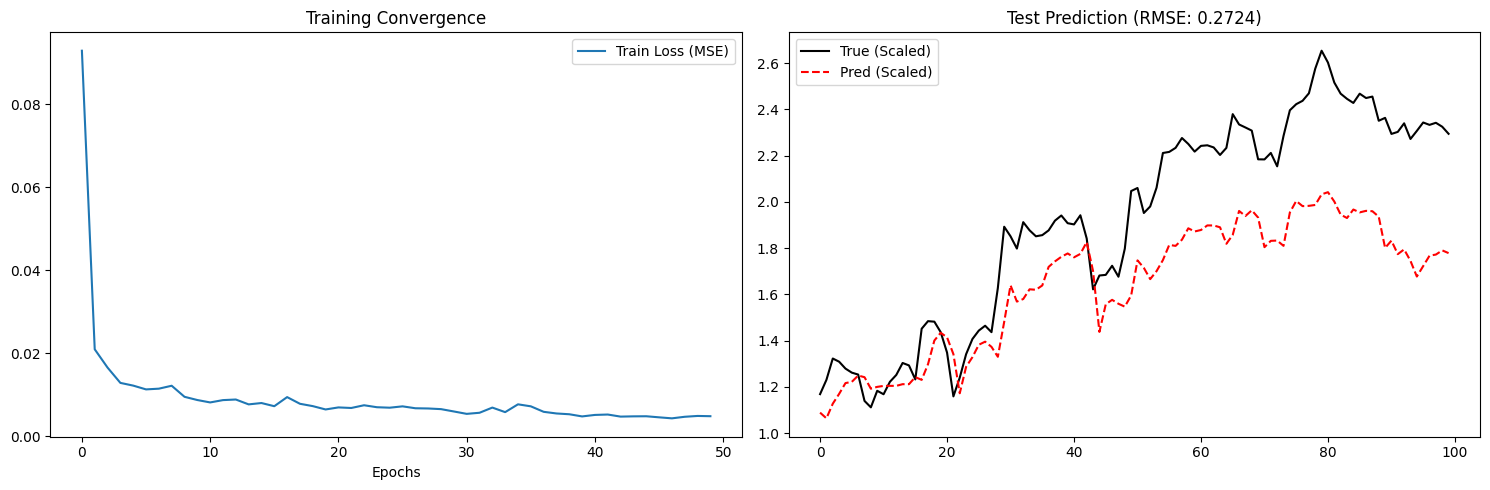

In [5]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Tính Metrics
mse = mean_squared_error(actual, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, preds)

print(f"\n--- METRICS ---")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history, label='Train Loss (MSE)')
plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.legend()

# Plot Predictions
plt.subplot(1, 2, 2)
plt.plot(actual[-100:], label='True (Scaled)', color='black')
plt.plot(preds[-100:], label='Pred (Scaled)', color='red', linestyle='--')
plt.title(f'Test Prediction (RMSE: {rmse:.4f})')
plt.legend()

plt.tight_layout()
plt.show()

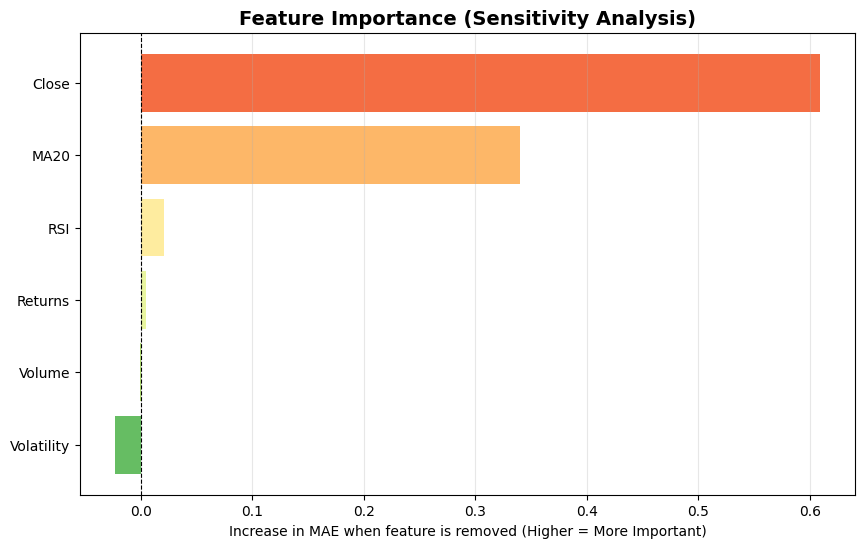

In [8]:
# --- BLOCK 6: FEATURE SENSITIVITY ANALYSIS ---
def analyze_sensitivity(model, test_loader, feature_cols, device):
    model.eval()
    sensitivity_results = {}

    # 1. Tính MAE cơ bản (Baseline)
    base_errors = []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb.to(device))
            base_errors.append(torch.abs(preds.squeeze() - yb.to(device)).cpu().numpy())
    baseline_mae = np.mean(np.concatenate(base_errors))

    # 2. Can thiệp vào từng đặc trưng
    for i, col_name in enumerate(feature_cols):
        perturbed_errors = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb_perturbed = xb.clone().to(device)
                # Đưa đặc trưng thứ i về 0 để xem mô hình mất phương hướng ra sao
                xb_perturbed[:, :, i] = 0
                preds = model(xb_perturbed)
                perturbed_errors.append(torch.abs(preds.squeeze() - yb.to(device)).cpu().numpy())

        feature_mae = np.mean(np.concatenate(perturbed_errors))
        # Độ nhạy = Lỗi tăng thêm (Delta MAE)
        sensitivity_results[col_name] = feature_mae - baseline_mae

    # Trực quan hóa kết quả
    sens_df = pd.DataFrame(list(sensitivity_results.items()),
                          columns=['Feature', 'Importance']).sort_values('Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(sens_df)))
    plt.barh(sens_df['Feature'], sens_df['Importance'], color=colors)
    plt.axvline(0, color='black', lw=0.8, linestyle='--')
    plt.title("Feature Importance (Sensitivity Analysis)", fontsize=14, fontweight='bold')
    plt.xlabel("Increase in MAE when feature is removed (Higher = More Important)")
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    return sens_df

# Create test_loader for sensitivity analysis
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_np[split:]), torch.from_numpy(y_np[split:])), batch_size=32, shuffle=False)

# Thực thi (Biến 'feature_cols' đã có sẵn trong Block 1 của bạn)
sensitivity_df = analyze_sensitivity(model, test_loader, feature_cols, device)


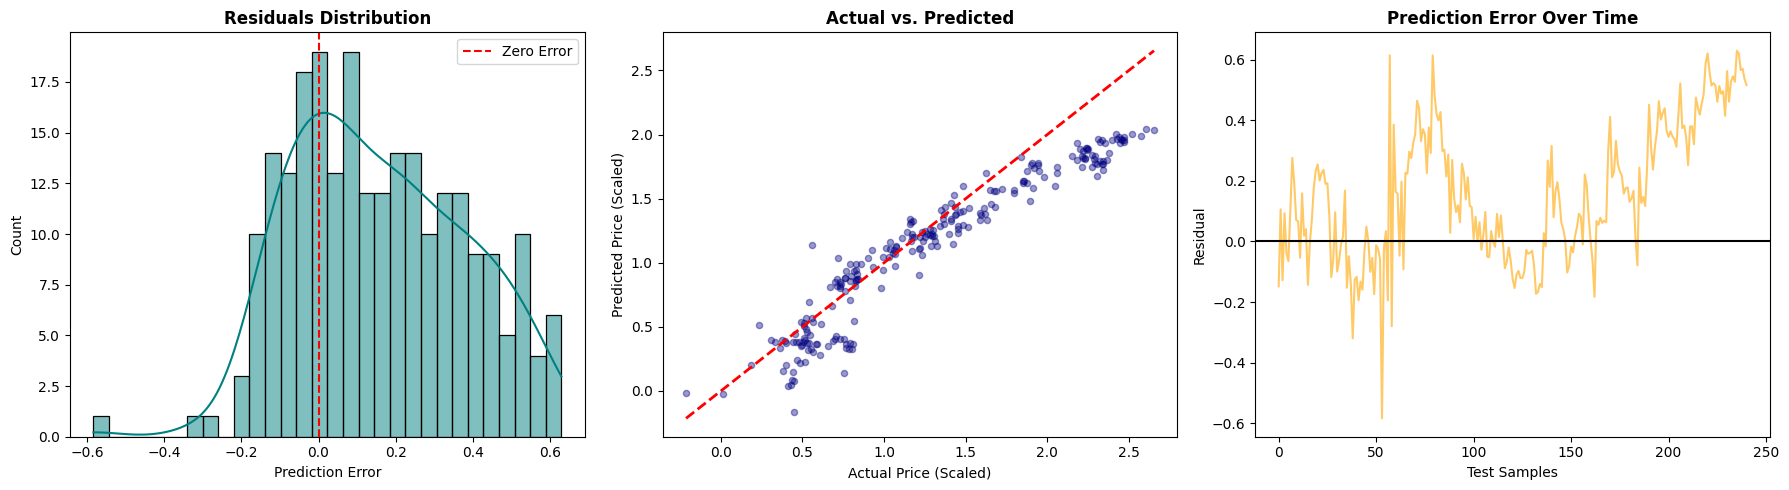

In [9]:
# --- BLOCK 7: ERROR ANALYSIS DASHBOARD ---
import seaborn as sns
def plot_error_analysis(actual, predictions):
    # Tính toán phần dư (Residuals)
    actual = actual.flatten()
    predictions = predictions.flatten()
    residuals = actual - predictions

    plt.figure(figsize=(18, 5))

    # 1. Biểu đồ phân phối sai số
    plt.subplot(1, 3, 1)
    sns.histplot(residuals, kde=True, color='teal', bins=30)
    plt.axvline(0, color='red', linestyle='--', label='Zero Error')
    plt.title("Residuals Distribution", fontweight='bold')
    plt.xlabel("Prediction Error")
    plt.legend()

    # 2. Biểu đồ Scatter: Giá trị thực vs Dự báo
    plt.subplot(1, 3, 2)
    plt.scatter(actual, predictions, alpha=0.4, s=20, color='navy')
    # Đường chéo 45 độ (Dự báo hoàn hảo)
    min_val = min(actual.min(), predictions.min())
    max_val = max(actual.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')
    plt.title("Actual vs. Predicted", fontweight='bold')
    plt.xlabel("Actual Price (Scaled)")
    plt.ylabel("Predicted Price (Scaled)")

    # 3. Biểu đồ sai số theo thời gian
    plt.subplot(1, 3, 3)
    plt.plot(residuals, color='orange', alpha=0.6)
    plt.axhline(0, color='black', linestyle='-')
    plt.title("Prediction Error Over Time", fontweight='bold')
    plt.xlabel("Test Samples")
    plt.ylabel("Residual")

    plt.tight_layout()
    plt.show()

# Thực thi (Biến 'actual' và 'preds' đã được tính ở Block 4 của bạn)
plot_error_analysis(actual, preds)